#**CA684 Machine Learning Assignment**

Dublin City University has teamed up with Etsy to create the 2024 CA684 Machine Learning assignment.italicized text

##**Etsy**

Etsy is the global marketplace for unique and creative goods. It’s home to a universe of special, extraordinary items, from unique handcrafted pieces to vintage treasures. Etsy operates two-sided online marketplaces that collectively connect nearly 100 million passionate and creative buyers and 7.7 million sellers around the world. Buyers come to the Etsy marketplace for meaningful, one-of-a-kind items handcrafted and curated with passion and expertise by our creative entrepreneurs. We are focused on attracting potential buyers to Etsy for everyday items that have meaning and those “special” purchase occasions that happen throughout the year. These include items that reflect an individual’s unique style; gifting that demonstrates thought and care; and celebrations that express creativity and fun. On Etsy, someone searches for …  
● Wallart every two seconds
● Wedding-related items every two seconds
● Gift-related items every second
● Antique or vintage items every half a second

##**Challenge**

Etsyhasnearly100Millionactivelistingsontheetsy.commarketplaceforsalefrommorethan5 millionactivesellers.Youareprovidedasubsetof thoseproductsasthetrainingdata.
The task is to leverage the training dataset to learn patterns from and to predict the following attributes on an unseen test dataset given a products’ information:

● topcategory id
● bottom category id
● primary color id
● secondary color id

The goal is to maximize F1 for each of the classes on each attribute to predict (top category, bottom category, primary color and secondary color). Your approaches and models will be benchmarked against a hidden test dataset.

See the getting-started notebook for further details and code to get you started. In order to download the dataset, please sign the NDA first. Happy Hacking! Disclaimer: dataset should only be used for the purposes of the assignment and in any case should be shared or distributed elsewhere.

In [1]:
# libraries
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
!pip install pyarrow
import pyarrow as pa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 22.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# set random seed
np.random.seed(seed=42)
data_dir = Path('/content/drive/MyDrive/data')



In [4]:
target_dir = data_dir / "/content/drive/MyDrive/data/2024"
target_dir


PosixPath('/content/drive/MyDrive/data/2024')

In [5]:
train_dir=target_dir/"/content/drive/MyDrive/data/2024/train"
test_dir=target_dir/"/content/drive/MyDrive/data/2024/test"
train_dir,test_dir


(PosixPath('/content/drive/MyDrive/data/2024/train'),
 PosixPath('/content/drive/MyDrive/data/2024/test'))

In [6]:
parquet_filenames_train =train_dir
parquet_filenames_test =test_dir


In [7]:
All_file_list=list(target_dir.glob("*/*.parquet"))
All_file_list


[PosixPath('/content/drive/MyDrive/data/2024/test/part-00004-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00001-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00007-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00003-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00005-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00006-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00000-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00002-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00010-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00013-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00012-of-00362.parquet'),
 PosixPath('/content/drive/MyDrive/data/2024/test/part-00011-of-00362.parquet'),
 PosixPath('/content/drive/M

## Exploratory Data Analysis

It is important to familiarize yourself with the dataset by using measures of centrality (e.g. mean) and statistical dispersion (e.g. variance) and data visualization methods. The following is just some Pandas preprocessing and Matplotlib visualizations to get you started. Feel free to explore the data much further and come up with ideas that might help you in the task!

In [71]:
def read_data(directory):
    """Read parquet data from multiple files in a directory."""
    # List all parquet files in the directory
    parquet_files = list(directory.glob("*.parquet"))

    # Read each parquet file and collect them in a list
    dataframes = [pd.read_parquet(file) for file in parquet_files]

    # Concatenate all dataframes into a single dataframe
    return pd.concat(dataframes, ignore_index=True)

In [72]:
df_train = read_data(train_dir)


In [ ]:
f"Number of rows in train: {len(df_train):,}"


'Number of rows in train: 229,624'

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"


'Number of columns in train: 26'

In [ ]:
list(df_train.columns)


['product_id',
 'title',
 'description',
 'tags',
 'type',
 'room',
 'craft_type',
 'recipient',
 'material',
 'occasion',
 'holiday',
 'art_subject',
 'style',
 'shape',
 'pattern',
 'bottom_category_id',
 'bottom_category_text',
 'top_category_id',
 'top_category_text',
 'primary_color_id',
 'primary_color_text',
 'secondary_color_id',
 'secondary_color_text',
 'image/encoded',
 'image/width',
 'image/height']

In [ ]:
df_train.iloc[0]


product_id                                                      699437355
title                   Children&#39;s circle skirt BLUE GALAXY made o...
description             The fuxandfriends children&#39;s full circle s...
tags                                                                     
type                                                             physical
room                                                                     
craft_type                                                               
recipient                                                                
material                                                                 
occasion                                                                 
holiday                                                                  
art_subject                                                              
style                                                                    
shape                                 

In [ ]:
df_train.head(2)


,product_id,title,description,tags,type,room,craft_type,recipient,material,occasion,...,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,,physical,,,,,,...,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,,,,,birthday,...,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475


In [ ]:
 # Function to check the missing value count and percentage in descending order

def check_missing_values(read_data):
    missing_value_count = read_data.isnull().sum() # Count of missing values in each column
    missing_value_percentage = (missing_value_count / len(read_data)) * 100 # Percentage of missing values in each column
    result = pd.DataFrame({'Column': missing_value_count.index,
                           'Missing_Value_Count': missing_value_count.values,
                           'Missing_Value_Percentage': missing_value_percentage.values})
    result = result.sort_values(by='Missing_Value_Count', ascending=False) # Sort by missing value count

    return result
check_missing_values(df_train)

,Column,Missing_Value_Count,Missing_Value_Percentage
0,product_id,0,0.0
1,title,0,0.0
2,description,0,0.0
3,tags,0,0.0
4,type,0,0.0
5,room,0,0.0
6,craft_type,0,0.0
7,recipient,0,0.0
8,material,0,0.0
9,occasion,0,0.0


In [ ]:
def finding_missing_values(read_data):
    # Convert common missing value indicators besides NaN (like empty strings) to NaN
    read_data = read_data.replace('', np.nan)  # Adjusting this line to include any other placeholders used in the dataset

    # Calculate the count and percentage of missing values for each column
    count_of_missing_values = read_data.isnull().sum()
    percentage_of_missing_value = (count_of_missing_values / len(read_data)) * 100

    # Create a DataFrame with the results
    result = pd.DataFrame({
        'Column': count_of_missing_values.index,
        'count_of_missing_values': count_of_missing_values.values,
        'percentage_of_missing_value': percentage_of_missing_value.values
    })

    # Filter to show columns with missing values and sort by count
    result = result.sort_values('count_of_missing_values', ascending=False)

    return result
finding_missing_values(df_train)

,Column,count_of_missing_values,percentage_of_missing_value
13,shape,227137,98.916925
11,art_subject,226885,98.807180
5,room,220686,96.107550
7,recipient,218815,95.292739
14,pattern,218042,94.956102
12,style,213730,93.078250
8,material,209384,91.185590
6,craft_type,201862,87.909800
10,holiday,183359,79.851845
9,occasion,171550,74.709090


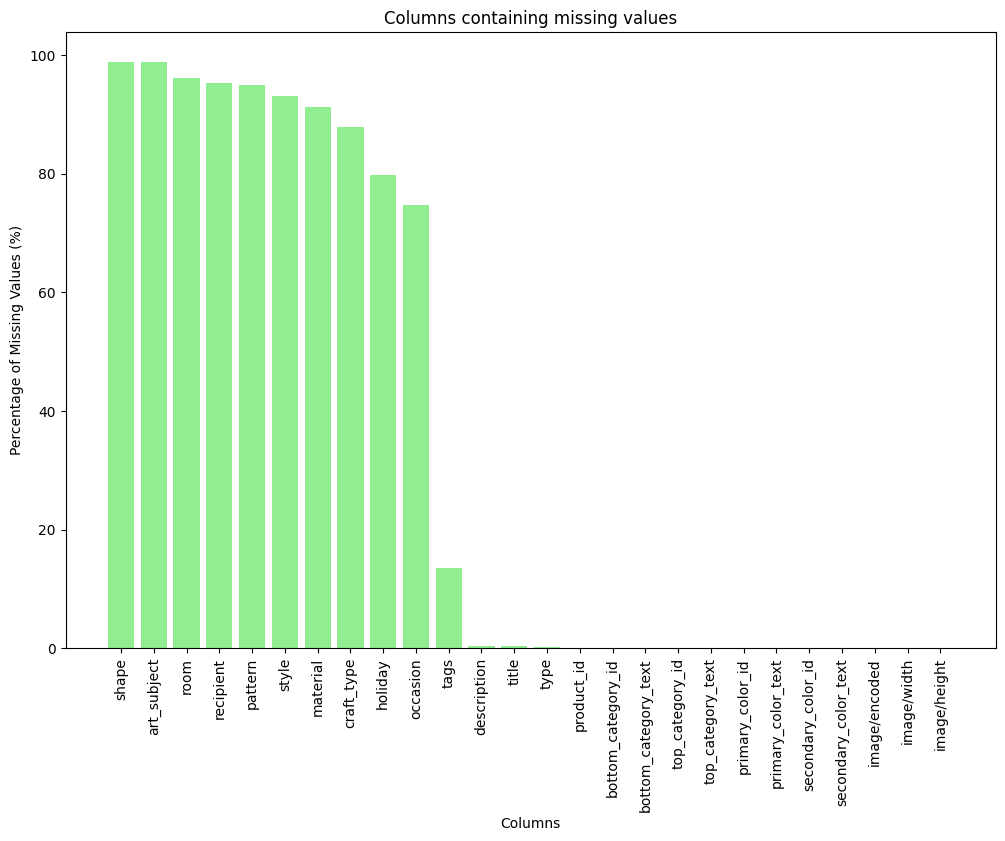

In [ ]:
def plot_missing_values(read_data):
    # First, we call the function to find missing values and store the result
    missing_data = finding_missing_values(read_data)

    # Now, let's plot the results
    plt.figure(figsize=(12, 8))  # Set the figure size for better readability
    plt.bar(missing_data['Column'], missing_data['percentage_of_missing_value'], color='lightgreen')
    plt.xlabel('Columns')  # Label for the x-axis
    plt.ylabel('Percentage of Missing Values (%)')  # Label for the y-axis
    plt.title('Columns containing missing values')  # Title of the graph
    plt.xticks(rotation=90)
    plt.show()
plot_missing_values(df_train)

In [ ]:
#Function to drop columns with missing values greater than 70%
def columns_dropped_containing_missing_values(read_data, threshold=70):
    read_data = read_data.replace('', np.nan)  # Adjusting this line to include any other placeholders used in the dataset
    percentage_of_missing_value = (read_data.isnull().sum() / len(read_data)) * 100 # Calculate percentage of missing values in each column
    dropped_columns = percentage_of_missing_value[percentage_of_missing_value > threshold].index # Columns to drop
    read_data = read_data.drop(columns=dropped_columns) # Drop columns
    return read_data

df_train = columns_dropped_containing_missing_values(df_train, threshold=70)

In [ ]:
f"Number of columns in train: {len(df_train.columns):,}"


'Number of columns in train: 16'

In [ ]:
df_train.head(5)

,product_id,title,description,tags,type,bottom_category_id,bottom_category_text,top_category_id,top_category_text,primary_color_id,primary_color_text,secondary_color_id,secondary_color_text,image/encoded,image/width,image/height
0,699437355,Children&#39;s circle skirt BLUE GALAXY made o...,The fuxandfriends children&#39;s full circle s...,NaN,physical,426,clothing.girls_clothing.skirts,5,clothing,2,blue,2,blue,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,426
1,1323699538,"Cow Birthday Tutu for kids, Farm Theme Bday Ou...",💄This listing is for the TUTU ONLY (double rib...,"birthday outfit,girls birthday shirt,Tutu outf...",physical,426,clothing.girls_clothing.skirts,5,clothing,11,pink,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,475
2,1142910558,"Zebra print tutu, animal print Skirt, World bo...",All tutus are handmade to order with two layer...,"black and white tutu,striped skirt,zebra tutu,...",physical,426,clothing.girls_clothing.skirts,5,clothing,17,white,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,396
3,1320296928,"Lilac Tutu Rainbow Dots // Girl&#39;s Tutu, Tu...",Step aside because the princess pop star is he...,"tutu,girls skirt,sparkling tutu,fun skirt,ball...",physical,426,clothing.girls_clothing.skirts,5,clothing,12,purple,13,rainbow,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570
4,854901795,Bumblebee tutu yellow and black tutu halloween...,"Sparkle, shimmer, twirl and spin,\nThis tutu&#...","dog tutu,fluffy tutu,dance tutu,skirt,flower g...",physical,426,clothing.girls_clothing.skirts,5,clothing,18,yellow,1,black,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,570,570


In [ ]:
f"Number of unique products in train: {len(df_train['product_id'].unique()):,}"


'Number of unique products in train: 229,624'

In [ ]:
df_train['type'].unique()


array(['physical', 'download', nan], dtype=object)

In [ ]:
df_train['type'].value_counts(dropna=False)

type
physical    218568
download     10708
NaN            348
Name: count, dtype: int64

In [ ]:
COLORS = df_train['primary_color_id'].unique()
NUM_COLORS = len(COLORS)
f"Number of primary colors in train: {NUM_COLORS:,}"

'Number of primary colors in train: 19'

In [ ]:
f"Number of top categories in train: {len(df_train['top_category_text'].unique()):,}"


'Number of top categories in train: 15'

In [ ]:
pd.value_counts(df_train['top_category_text'], sort=True, ascending=False)

top_category_text
home_and_living                54600
craft_supplies_and_tools       33393
clothing                       30143
toys_and_games                 13835
accessories                    12416
paper_and_party_supplies       12207
bath_and_beauty                11327
weddings                       10143
shoes                           8892
art_and_collectibles            8716
jewelry                         7822
electronics_and_accessories     7474
bags_and_purses                 6650
books_movies_and_music          6262
pet_supplies                    5744
Name: count, dtype: int64

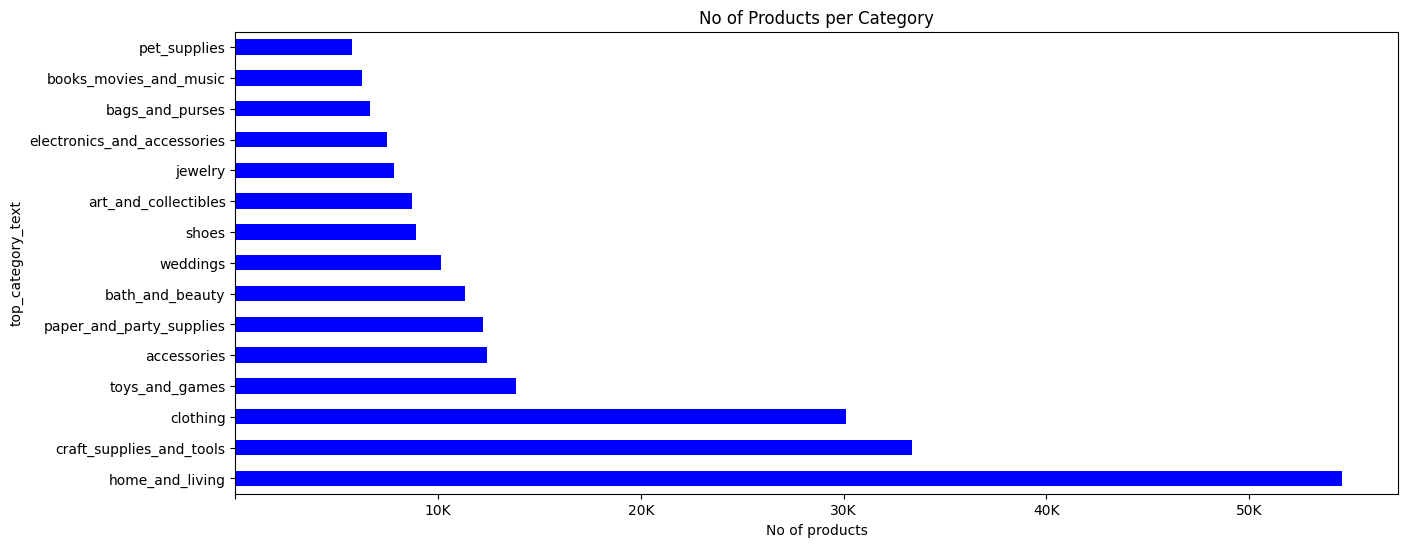

In [ ]:
figsize = (15, 6)
column = 'top_category_text'
x_limit = 60000
x_step = 10000
color = 'blue'

figure, ax = plt.subplots(figsize=figsize)
pd.value_counts(
    df_train[column],
    sort=True, ascending=False).plot.barh(color=color)
plt.title(f"No of Products per Category")
xlabels = [f'{x // 1000:,}K' for x in range(0, x_limit, x_step)]
plt.xticks(range(0, x_limit, x_step), xlabels)
plt.xlabel('No of products')
plt.setp(ax.get_xticklabels()[0], visible=False)
plt.show()

In [ ]:
f"Number of bottom categories in train: {len(df_train['bottom_category_text'].unique()):,}"


'Number of bottom categories in train: 2,609'

In [ ]:
from sklearn.model_selection import train_test_split

df_training, df_validation = train_test_split(
    df_train,
    test_size=0.1,
    stratify=df_train['bottom_category_text'],
    random_state=42)

In [ ]:
f"Number of products for training: {len(df_training):,}"

'Number of products for training: 206,661'

In [ ]:
f"Number of products for validation: {len(df_validation):,}"

'Number of products for validation: 22,963'

In [ ]:
df_training['bottom_category_text'].value_counts()

bottom_category_text
accessories.scarves_and_wraps.scarves                                               88
jewelry.earrings.dangle_earrings.chandbalis                                         88
craft_supplies_and_tools.closures_and_fasteners.buttons                             88
toys_and_games.sports_and_outdoor_games.martial_arts_and_boxing.boxing_gloves       88
home_and_living.kitchen_and_dining.dining_and_serving.cake_stands                   88
                                                                                    ..
clothing.girls_clothing.baby_girls_clothing.socks_and_leg_warmers                   40
home_and_living.furniture.entryway_furniture.standing_coat_racks                    40
home_and_living.lighting.light_accessories                                          39
clothing.womens_clothing.pajamas_and_robes.sleep_masks_and_blindfolds.blindfolds    38
craft_supplies_and_tools.doll_and_model_supplies.noise_makers                       38
Name: count, Length: 2

In [ ]:
df_validation['bottom_category_text'].value_counts()

bottom_category_text
toys_and_games.toys.baby_and_toddler_toys.shapes_and_colors                                10
home_and_living.food_and_drink.snacks                                                      10
clothing.womens_clothing.jeans                                                             10
home_and_living.spirituality_and_religion.religious_home_and_decor.thali_and_thali_sets    10
art_and_collectibles.fiber_arts.quilting                                                   10
                                                                                           ..
craft_supplies_and_tools.raw_materials.clay_and_ceramic                                     4
electronics_and_accessories.parts_and_electrical.testing_and_calibration                    4
home_and_living.furniture.entryway_furniture.standing_coat_racks                            4
home_and_living.lighting.light_accessories                                                  4
jewelry.earrings.kaan_chains           

In [ ]:
df_training['top_category_text'].value_counts()

top_category_text
home_and_living                49140
craft_supplies_and_tools       30056
clothing                       27139
toys_and_games                 12448
accessories                    11173
paper_and_party_supplies       10984
bath_and_beauty                10187
weddings                        9128
shoes                           8001
art_and_collectibles            7846
jewelry                         7040
electronics_and_accessories     6727
bags_and_purses                 5986
books_movies_and_music          5636
pet_supplies                    5170
Name: count, dtype: int64

In [ ]:
df_validation['top_category_text'].value_counts()

top_category_text
home_and_living                5460
craft_supplies_and_tools       3337
clothing                       3004
toys_and_games                 1387
accessories                    1243
paper_and_party_supplies       1223
bath_and_beauty                1140
weddings                       1015
shoes                           891
art_and_collectibles            870
jewelry                         782
electronics_and_accessories     747
bags_and_purses                 664
books_movies_and_music          626
pet_supplies                    574
Name: count, dtype: int64

# Training model for Top category ID

Applying logistic regression model to better handle textual data, potentially improving the model’s performance in terms of F1 score.

-CountVectorizer and TfidfTransformer: This setup uses CountVectorizer to tokenize text and count word occurrences, and TfidfTransformer to adjust for word frequency across documents.

-Parameter Tuning: The grid search now includes parameters for both the vectorization and the IDF transformation stages, allowing more detailed control over the feature extraction process.
-Grid Search: Expanded to explore a variety of configurations for both the text vectorization and the logistic regression model.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

# Assuming df_training and df_validation are your DataFrame variables

# Create a text pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

# Prepare training data
train_text = df_training[['title']].fillna('').agg(' '.join, axis=1).values
train_labels = df_training['top_category_text'].values

# Train the model
text_clf.fit(train_text, train_labels)

# Prepare validation data
val_text = df_validation[['title']].fillna('').agg(' '.join, axis=1).values
val_labels = df_validation['top_category_text'].values

# Prediction and evaluation
predictions = text_clf.predict(val_text)
f1_score = metrics.f1_score(val_labels, predictions, average='weighted')
print(f"F1 score: {f1_score:.4f}")

print(metrics.classification_report(val_labels, predictions))
print(metrics.confusion_matrix(val_labels, predictions))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 score: 0.8128
                             precision    recall  f1-score   support

                accessories       0.76      0.75      0.75      1243
       art_and_collectibles       0.71      0.52      0.60       870
            bags_and_purses       0.82      0.73      0.77       664
            bath_and_beauty       0.87      0.77      0.82      1140
     books_movies_and_music       0.83      0.77      0.80       626
                   clothing       0.92      0.94      0.93      3004
   craft_supplies_and_tools       0.79      0.81      0.80      3337
electronics_and_accessories       0.86      0.80      0.83       747
            home_and_living       0.78      0.90      0.83      5460
                    jewelry       0.83      0.80      0.81       782
   paper_and_party_supplies       0.79      0.77      0.78      1223
               pet_supplies       0.89      0.79      0.84       574
                      shoes       0.95      0.91      0.93       891
             toy

###By using Random Forest

In [ ]:
#Prediction using Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split

text_clf = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(n_estimators=100, random_state=42)),
              ])
# Prepare training data
train_text = df_training[['title']].fillna('').agg(' '.join, axis=1).values
train_labels = df_training['top_category_text'].values

# Train the model
text_clf.fit(train_text, train_labels)

# Prepare validation data
val_text = df_validation[['title']].fillna('').agg(' '.join, axis=1).values
val_labels = df_validation['top_category_text'].values

# Prediction and evaluation
predictions = text_clf.predict(val_text)
f1_score = metrics.f1_score(val_labels, predictions, average='weighted')
print(f"F1 score: {f1_score:.4f}")

print(metrics.classification_report(val_labels, predictions))
print(metrics.confusion_matrix(val_labels, predictions))


F1 score: 0.8089
                             precision    recall  f1-score   support

                accessories       0.83      0.73      0.78      1243
       art_and_collectibles       0.75      0.42      0.54       870
            bags_and_purses       0.82      0.79      0.80       664
            bath_and_beauty       0.88      0.76      0.81      1140
     books_movies_and_music       0.86      0.74      0.80       626
                   clothing       0.88      0.95      0.91      3004
   craft_supplies_and_tools       0.84      0.78      0.81      3337
electronics_and_accessories       0.90      0.78      0.83       747
            home_and_living       0.72      0.92      0.81      5460
                    jewelry       0.80      0.84      0.82       782
   paper_and_party_supplies       0.83      0.79      0.81      1223
               pet_supplies       0.88      0.84      0.86       574
                      shoes       0.93      0.93      0.93       891
             toy

###By using Decision Trees

In [ ]:
#Prediction using Decision Tree

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline
text_clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Add CountVectorizer as the first step in the pipeline
    ('tfidf', TfidfTransformer()),  # Add TfidfTransformer as the second step in the pipeline
    ('classifier', DecisionTreeClassifier())  # Add the classifier as the final step in the pipeline
])
# Prepare training data
train_text = df_training[['title']].fillna('').agg(' '.join, axis=1).values
train_labels = df_training['top_category_text'].values

# Train the model
text_clf.fit(train_text, train_labels)

# Prepare validation data
val_text = df_validation[['title']].fillna('').agg(' '.join, axis=1).values
val_labels = df_validation['top_category_text'].values

# Prediction and evaluation
predictions = text_clf.predict(val_text)
f1_score = metrics.f1_score(val_labels, predictions, average='weighted')
print(f"F1 score: {f1_score:.4f}")

print(metrics.classification_report(val_labels, predictions))
print(metrics.confusion_matrix(val_labels, predictions))


NameError: name 'df_training' is not defined

##By applying hypertuning using logistic regression


In [48]:

#By applying hypertuning using logistic regression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score

# Load data and prepare columns
df_train.fillna('', inplace=True)

# Convert all columns intended for text data to string and combine them
df_train['text_data'] = df_train[['product_id','title','description','tags']].astype(str).apply(lambda x: ' '.join(x), axis=1)
train_texts = df_train['text_data'].values
train_labels = df_train['top_category_id'].values

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

text_clf = Pipeline([
    ('vect', CountVectorizer(max_features=5000)),  # Limit number of features
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Define a smaller parameter grid to search
param_grid = {
    'clf__C': [1, 10],  # Reduced number of options
    'clf__penalty': ['l2'],  # Only L2 due to solver constraints
    'vect__ngram_range': [(1, 1)],  # Only unigrams
    'tfidf__use_idf': [True],  # Only using IDF
}

# Create a GridSearchCV object with fewer CV folds
grid_search = GridSearchCV(text_clf, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=1)  # Reduced CV folds

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameter set found on development set
print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the best grid-searched model on the validation data
best_Top_model = grid_search.best_estimator_
predictions = best_Top_model.predict(X_val)

# Calculating the F1 score of the best model
f1 = f1_score(y_val, predictions, average='weighted')
print(f"F1 score: {f1:.4f}")


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:
{'clf__C': 10, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
F1 score: 0.8423


### Test Dataset for Top_category_id





In [49]:
df_test = read_data(test_dir)


In [50]:
df_test['text_data'] = df_test[['product_id','title','description','tags']].astype(str).apply(lambda x: ' '.join(x), axis=1)
test_texts = df_test['text_data'].values



In [51]:
test_pred=best_Top_model.predict(test_texts)

In [52]:
test_pred

array([ 8,  8,  8, ..., 13,  2,  2])

In [53]:
df_predictions = pd.DataFrame()

In [54]:
df_predictions['product_id'] = df_test['product_id']

In [55]:
df_predictions["top_category_id"] = test_pred
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = extract_values
df_predictions["secondary_color_id"] = np.zeros(len(df_test), dtype=int)

In [56]:
df_predictions

,product_id,top_category_id,bottom_category_id,primary_color_id,secondary_color_id
0,609243070,8,0,13,0
1,1398220960,8,0,10,0
2,1436000310,8,0,10,0
3,719170010,8,0,13,0
4,1242444210,8,0,4,0
...,...,...,...,...,...
25509,1208153360,2,0,2,0
25510,1189755880,2,0,13,0
25511,1601636070,13,0,4,0
25512,980830720,2,0,2,0


In [57]:
df_predictions.to_csv('/content/drive/MyDrive/Etsy/Ronit_Prediction_Output.csv',index=False)

##Training model for bottom category ID using svm

-Support Vector Machines (SVMs) are particularly useful for training classification models for a "bottom category" in a dataset, where the task often involves distinguishing between many fine-grained categories.





In [73]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, classification_report
from scipy.sparse import vstack

# Load and prepare data
df_train.fillna('', inplace=True)
df_train['combined_text'] = df_train[['product_id', 'title', 'description', 'tags']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

# Split data
df_train, df_validation = train_test_split(df_train, test_size=0.2, random_state=42)

# Define a text processing pipeline
text_pipeline = Pipeline([
    ('vect', CountVectorizer(max_df=0.75, min_df=5, ngram_range=(1, 2), max_features=5000)),
    ('tfidf', TfidfTransformer())
])

# Fit the vectorizer pipeline to the training data
text_pipeline.fit(df_train['combined_text'].values)

# Function to process a DataFrame batch
def process_batch(data, vectorizer):
    """ Convert text data in batch to vectorized format """
    return vectorizer.transform(data['combined_text'].values)

# Batch processing
batch_size = 5000
train_features = vstack([process_batch(df_train[i:i+batch_size], text_pipeline) for i in range(0, len(df_train), batch_size)])

# Train labels
train_labels = df_train['bottom_category_id'].values

# Define the classifier pipeline with feature selection
classifier_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=5000, tol=0.01))),
    ('clf', LinearSVC(penalty="l2"))
])

# Parameters for GridSearchCV
param_grid = {
    'feature_selection__estimator__C': [1],  # Simplified for speed
    'clf__C': [1]  # Simplified for speed
}

# Setup GridSearchCV
try:
    grid_search = GridSearchCV(classifier_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=4)  # Reduced CV folds and adjusted n_jobs
    grid_search.fit(train_features, train_labels)
    print("Best parameters:", grid_search.best_params_)
    best_bottom_model = grid_search.best_estimator_

    # Validation
    val_text = text_pipeline.transform(df_validation['combined_text'].values)
    val_labels = df_validation['bottom_category_id'].values
    predictions = best_bottom_model.predict(val_text)

    # F1 score and report
    f1 = f1_score(val_labels, predictions, average='weighted', zero_division=0)
    print(f"F1 score: {f1:.4f}")
    print(classification_report(val_labels, predictions, zero_division=0))

except Exception as e:
    print("An error occurred during Grid Search:", e)


Best parameters: {'clf__C': 1, 'feature_selection__estimator__C': 1}
F1 score: 0.5881
              precision    recall  f1-score   support

           1       0.12      0.05      0.07        21
           2       0.83      0.48      0.61        21
           3       0.74      0.85      0.79        27
           4       0.65      0.72      0.68        18
           5       0.80      0.71      0.75        17
           6       0.50      0.25      0.33        12
           7       0.62      0.70      0.65        23
           8       0.67      0.71      0.69        14
           9       0.12      0.06      0.08        16
          10       0.41      0.54      0.47        13
          11       0.85      0.85      0.85        20
          12       0.85      0.65      0.73        17
          13       0.71      0.79      0.75        19
          14       0.73      0.89      0.80        18
          15       0.70      0.95      0.81        20
          16       0.42      0.24      0.30      

### Test Dataset for bottom_category_id


In [74]:
df_test = read_data(test_dir)


In [80]:
df_test['combined_text'] = df_test[['product_id', 'title', 'description', 'tags']].apply(lambda x: ' '.join(x.astype(str)), axis=1)
test_texts = df_test['combined_text'].values


In [81]:
val_text_test = text_pipeline.transform(df_test['combined_text'].values)


In [82]:
predicted_test=best_bottom_model.predict(val_text_test)

In [83]:
predicted_test

array([12396, 12396, 12396, ...,   186,   176,   186])

In [84]:
df_predictions = pd.DataFrame()

In [85]:
df_predictions['product_id'] = df_test['product_id']

In [86]:
df_predictions["top_category_id"] = test_pred
df_predictions["bottom_category_id"] = predicted_test
df_predictions["primary_color_id"] = extract_values
df_predictions["secondary_color_id"] = drawn_value

In [88]:
df_predictions.to_csv('/content/drive/MyDrive/Etsy/Ronit_Prediction_Output.csv',index=False)

##Training model for primary_color_id using CNN

-Convolutional Neural Networks (CNNs) are particularly well-suited for tasks involving image data, such as classifying primary in images.

-For tasks like classifying both primary and secondary colors, CNNs can be effectively combined with other neural network architectures.




In [30]:
def read_data(directory,columns=None):
    """Read parquet data from multiple files in a directory."""
    # List all parquet files in the directory
    parquet_files = list(directory.glob("*.parquet"))

    # Read each parquet file and collect them in a list
    dataframes = [pd.read_parquet(file,columns=columns) for file in parquet_files]

    # Concatenate all dataframes into a single dataframe
    return pd.concat(dataframes, ignore_index=True)

In [31]:
columns=["primary_color_id","secondary_color_id","image/encoded"]


In [32]:
df_train = read_data(train_dir,columns=columns)

In [33]:
df_train

,primary_color_id,secondary_color_id,image/encoded
0,2,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,11,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,17,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,12,13,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,18,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...
229619,6,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
229620,12,13,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
229621,17,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
229622,1,14,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [34]:

# Image decoding and resizing (placeholder function)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
def proceeding_img(taking_images):
    transform_augment_2= transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),  # Example augmentation
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Process each byte-encoded image
    prepared_images = []
    for taking_images in taking_images:
        # Decode the image bytes into a PIL image
        image = Image.open(io.BytesIO(taking_images))

        # Apply the transformations
        prepared_img = transform_augment_2(image)
        prepared_images.append(prepared_img)

    # Stack all processed images into a single tensor
    return torch.stack(prepared_images)

all_images = proceeding_img(df_train['image/encoded'])
# Label encoding for primary_color_id

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['primary_color_id'])

use_tensor=torch.tensor(y)

dataset = TensorDataset(all_images, use_tensor)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

my_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

my_test_loader=DataLoader(test_dataset)



In [35]:
class improved_CNN_Model(nn.Module):
    def __init__(self):
        super(improved_CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 19)  # Output layer with 19 units for primary color IDs
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization

    def forward(self, v):
        v = self.pool(F.relu(self.conv1(v)))
        v = self.pool(F.relu(self.conv2(v)))
        v = v.view(-1, 64 * 16 * 16)  # Flatten the output for fully connected layers
        v = self.dropout(v)  # Applying dropout
        v = F.relu(self.fc1(v))
        v = self.dropout(v)  # Applying dropout
        v = self.fc2(v)
        return v
device='cuda' if torch.cuda.is_available() else 'cpu'
device

# Define model, loss function, and optimizer
model_a = improved_CNN_Model().to(device)
criterioning = nn.CrossEntropyLoss()
optimizing = optim.Adam(model_a.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizing, step_size=5, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 5 epochs

# Training loop
numb_epochs = 20
best_val_of_acc = 0.0
for epoch in range(numb_epochs):
    model_a.train()
    scheduler.step()  # Update learning rate
    run_loss = 0.0
    correct = 0
    total = 0
    for inp, lab in my_train_loader:
        inp, lab = inp.to(device), lab.to(device)
        optimizing.zero_grad()
        ops = model_a(inp)
        losses = criterioning(ops, lab)
        losses.backward()
        optimizing.step()
        run_loss += losses.item() * inp.size(0)
        _, predicted = torch.max(ops, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum().item()
    epoch_loss = run_loss / len(train_dataset)
    acc_of_train = correct / total

    # Validation
    model_a.eval()
    correct_val = 0
    total_val = 0
    loss_val = 0.0
    with torch.no_grad():
        for inp, lab in my_test_loader:
            inp, lab = inp.to(device), lab.to(device)
            ops = model_a(inp)
            loss_val += criterioning(ops, lab).item() * inp.size(0)
            _, predicted = torch.max(ops, 1)
            total_val += lab.size(0)
            correct_val += (predicted == lab).sum().item()
    loss_val /= len(test_dataset)
    acc_of_val = correct_val / total_val

    print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Acc: {acc_of_train:.4f}, Val Loss: {loss_val:.4f}, Val Acc: {acc_of_val:.4f}")

    # Check for improvement in validation accuracy and save the model
    if acc_of_val > best_val_of_acc:
        torch.save(model_a.state_dict(), 'best_primary_model.pth')
        best_val_of_acc = acc_of_val

# After training, load the best model and evaluate it on the test dataset
best_of_model = improved_CNN_Model().to(device)
best_of_model.load_state_dict(torch.load('best_primary_model.pth'))
best_of_model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inp, lab in my_test_loader:
        inp, lab = inp.to(device), lab.to(device)
        ops = best_of_model(inp)
        _, predicted = torch.max(ops, 1)
        total_test += lab.size(0)
        correct_test += (predicted == lab).sum().item()
acc_of_test = correct_test / total_test
print(f"Test Accuracy: {acc_of_test:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0: Train Loss: 2.2676, Train Acc: 0.3307, Val Loss: 2.0864, Val Acc: 0.3790
Epoch 1: Train Loss: 2.1568, Train Acc: 0.3612, Val Loss: 2.0653, Val Acc: 0.3816
Epoch 2: Train Loss: 2.1234, Train Acc: 0.3699, Val Loss: 2.0368, Val Acc: 0.3916
Epoch 3: Train Loss: 2.1052, Train Acc: 0.3744, Val Loss: 2.0176, Val Acc: 0.3916
Epoch 4: Train Loss: 2.0318, Train Acc: 0.3913, Val Loss: 1.9666, Val Acc: 0.4057
Epoch 5: Train Loss: 2.0150, Train Acc: 0.3961, Val Loss: 1.9575, Val Acc: 0.4081
Epoch 6: Train Loss: 2.0084, Train Acc: 0.3987, Val Loss: 1.9598, Val Acc: 0.4098
Epoch 7: Train Loss: 2.0040, Train Acc: 0.3988, Val Loss: 1.9509, Val Acc: 0.4095
Epoch 8: Train Loss: 1.9998, Train Acc: 0.3998, Val Loss: 1.9486, Val Acc: 0.4100
Epoch 9: Train Loss: 1.9881, Train Acc: 0.4025, Val Loss: 1.9446, Val Acc: 0.4117
Epoch 10: Train Loss: 1.9855, Train Acc: 0.4024, Val Loss: 1.9431, Val Acc: 0.4120
Epoch 11: Train Loss: 1.9865, Train Acc: 0.4027, Val Loss: 1.9422, Val Acc: 0.4121
Epoch 12: Trai

Test data set for primary color

In [36]:
df_test = read_data(test_dir,columns=['image/encoded'])

In [37]:
all_images_test = proceeding_img(df_test['image/encoded'])


In [38]:
my_train_loader_test = DataLoader(all_images_test)

In [39]:
test_predict_results=[]
with torch.no_grad():
    for info in my_train_loader_test:
        info = info.to(device)
        predicts = best_of_model(info)
        _,predicted_test_outputs = torch.max(predicts, 1)
        test_predict_results.append(predicted_test_outputs)
        #total_test += lab.size(0)
        #correct_test += (predicted == lab).sum().item()


In [40]:
test_predict_results

[tensor([13]),
 tensor([10]),
 tensor([10]),
 tensor([13]),
 tensor([4]),
 tensor([2]),
 tensor([7]),
 tensor([16]),
 tensor([16]),
 tensor([13]),
 tensor([2]),
 tensor([16]),
 tensor([11]),
 tensor([1]),
 tensor([17]),
 tensor([2]),
 tensor([16]),
 tensor([16]),
 tensor([8]),
 tensor([16]),
 tensor([16]),
 tensor([2]),
 tensor([13]),
 tensor([2]),
 tensor([10]),
 tensor([4]),
 tensor([16]),
 tensor([2]),
 tensor([8]),
 tensor([16]),
 tensor([4]),
 tensor([8]),
 tensor([10]),
 tensor([16]),
 tensor([2]),
 tensor([13]),
 tensor([17]),
 tensor([4]),
 tensor([2]),
 tensor([2]),
 tensor([13]),
 tensor([2]),
 tensor([16]),
 tensor([2]),
 tensor([16]),
 tensor([16]),
 tensor([2]),
 tensor([2]),
 tensor([4]),
 tensor([8]),
 tensor([16]),
 tensor([4]),
 tensor([16]),
 tensor([16]),
 tensor([10]),
 tensor([4]),
 tensor([1]),
 tensor([4]),
 tensor([4]),
 tensor([2]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([16]),
 tensor([2]),
 tensor([2]),
 tensor([16]),
 tensor([13]),
 tensor([16]),


In [41]:
extract_values = [tensor.item() for tensor in test_predict_results]
print(extract_values)

[13, 10, 10, 13, 4, 2, 7, 16, 16, 13, 2, 16, 11, 1, 17, 2, 16, 16, 8, 16, 16, 2, 13, 2, 10, 4, 16, 2, 8, 16, 4, 8, 10, 16, 2, 13, 17, 4, 2, 2, 13, 2, 16, 2, 16, 16, 2, 2, 4, 8, 16, 4, 16, 16, 10, 4, 1, 4, 4, 2, 1, 1, 1, 16, 2, 2, 16, 13, 16, 16, 4, 1, 13, 7, 2, 4, 1, 4, 1, 4, 4, 15, 4, 1, 16, 2, 1, 1, 1, 4, 4, 4, 1, 2, 2, 10, 16, 2, 16, 1, 17, 1, 15, 2, 11, 16, 2, 2, 17, 10, 4, 13, 8, 10, 16, 4, 1, 1, 13, 4, 16, 0, 4, 2, 1, 4, 2, 2, 2, 8, 2, 2, 1, 4, 13, 16, 8, 4, 8, 1, 1, 8, 8, 2, 1, 13, 16, 13, 1, 1, 4, 4, 4, 4, 7, 4, 17, 10, 4, 11, 0, 7, 4, 16, 1, 13, 1, 2, 16, 1, 10, 2, 8, 1, 1, 11, 1, 1, 2, 16, 1, 4, 13, 2, 1, 7, 1, 2, 16, 1, 13, 1, 17, 2, 4, 4, 17, 8, 13, 13, 16, 2, 13, 1, 4, 16, 2, 2, 1, 10, 1, 13, 13, 1, 8, 8, 16, 8, 10, 10, 2, 16, 17, 4, 2, 4, 8, 8, 8, 1, 2, 0, 15, 4, 16, 1, 16, 0, 2, 16, 8, 4, 10, 2, 2, 13, 2, 16, 2, 2, 2, 16, 0, 10, 2, 2, 2, 2, 1, 1, 2, 2, 2, 4, 2, 2, 13, 1, 2, 16, 4, 15, 7, 4, 2, 16, 9, 16, 2, 8, 8, 2, 2, 4, 16, 4, 16, 11, 8, 16, 4, 4, 16, 16, 4, 4, 13, 4, 

In [42]:
df_predictions = pd.DataFrame()

In [43]:
df_predictions["top_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = extract_values
df_predictions["secondary_color_id"] = np.zeros(len(df_test), dtype=int)

In [45]:
df_predictions.to_csv('/content/drive/MyDrive/Etsy/Ronit_Prediction_Output.csv',index=False)

In [46]:
df_predictions

,top_category_id,bottom_category_id,primary_color_id,secondary_color_id
0,0,0,13,0
1,0,0,10,0
2,0,0,10,0
3,0,0,13,0
4,0,0,4,0
...,...,...,...,...
25509,0,0,2,0
25510,0,0,13,0
25511,0,0,4,0
25512,0,0,2,0


##Training model for secondary_color_id using CNN

-Convolutional Neural Networks (CNNs) are particularly well-suited for tasks involving image data, such as classifying primary and secondary colors in images.

-For tasks like classifying both primary and secondary colors, CNNs can be effectively combined with other neural network architectures.


In [58]:

# Image decoding and resizing (placeholder function)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
def proceeding_img(taking_images):
    transform_augment_2= transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.RandomHorizontalFlip(),  # Example augmentation
    transforms.RandomRotation(10),  # Rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Process each byte-encoded image
    prepared_images = []
    for taking_images in taking_images:
        # Decode the image bytes into a PIL image
        image = Image.open(io.BytesIO(taking_images))

        # Apply the transformations
        prepared_img = transform_augment_2(image)
        prepared_images.append(prepared_img)

    # Stack all processed images into a single tensor
    return torch.stack(prepared_images)

all_images = proceeding_img(df_train['image/encoded'])
# Label encoding for secondary_color_id

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['secondary_color_id'])

use_tensor=torch.tensor(y)

dataset = TensorDataset(all_images, use_tensor)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

my_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

my_test_loader=DataLoader(test_dataset)



In [59]:
class improved_CNN_Model(nn.Module):
    def __init__(self):
        super(improved_CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 19)  # Output layer with 19 units for secondary color IDs
        self.dropout = nn.Dropout(0.5)  # Adding dropout for regularization

    def forward(self, v):
        v = self.pool(F.relu(self.conv1(v)))
        v = self.pool(F.relu(self.conv2(v)))
        v = v.view(-1, 64 * 16 * 16)  # Flatten the output for fully connected layers
        v = self.dropout(v)  # Applying dropout
        v = F.relu(self.fc1(v))
        v = self.dropout(v)  # Applying dropout
        v = self.fc2(v)
        return v
device='cuda' if torch.cuda.is_available() else 'cpu'
device

# Define model, loss function, and optimizer
model_a = improved_CNN_Model().to(device)
criterioning = nn.CrossEntropyLoss()
optimizing = optim.Adam(model_a.parameters(), lr=0.001)

# Define learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizing, step_size=5, gamma=0.1)  # Reduce learning rate by a factor of 0.1 every 5 epochs

# Training loop
numb_epochs = 20
best_val_of_acc = 0.0
for epoch in range(numb_epochs):
    model_a.train()
    scheduler.step()  # Update learning rate
    run_loss = 0.0
    correct = 0
    total = 0
    for inp, lab in my_train_loader:
        inp, lab = inp.to(device), lab.to(device)
        optimizing.zero_grad()
        ops = model_a(inp)
        losses = criterioning(ops, lab)
        losses.backward()
        optimizing.step()
        run_loss += losses.item() * inp.size(0)
        _, predicted = torch.max(ops, 1)
        total += lab.size(0)
        correct += (predicted == lab).sum().item()
    epoch_loss = run_loss / len(train_dataset)
    acc_of_train = correct / total

    # Validation
    model_a.eval()
    correct_val = 0
    total_val = 0
    loss_val = 0.0
    with torch.no_grad():
        for inp, lab in my_test_loader:
            inp, lab = inp.to(device), lab.to(device)
            ops = model_a(inp)
            loss_val += criterioning(ops, lab).item() * inp.size(0)
            _, predicted = torch.max(ops, 1)
            total_val += lab.size(0)
            correct_val += (predicted == lab).sum().item()
    loss_val /= len(test_dataset)
    acc_of_val = correct_val / total_val

    print(f"Epoch {epoch}: Train Loss: {epoch_loss:.4f}, Train Acc: {acc_of_train:.4f}, Val Loss: {loss_val:.4f}, Val Acc: {acc_of_val:.4f}")

    # Check for improvement in validation accuracy and save the model
    if acc_of_val > best_val_of_acc:
        torch.save(model_a.state_dict(), 'best_secondary_model.pth')
        best_val_of_acc = acc_of_val

# After training, load the best model and evaluate it on the test dataset
best_of_model = improved_CNN_Model().to(device)
best_of_model.load_state_dict(torch.load('best_secondary_model.pth'))
best_of_model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inp, lab in my_test_loader:
        inp, lab = inp.to(device), lab.to(device)
        ops = best_of_model(inp)
        _, predicted = torch.max(ops, 1)
        total_test += lab.size(0)
        correct_test += (predicted == lab).sum().item()
acc_of_test = correct_test / total_test
print(f"Test Accuracy: {acc_of_test:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 0: Train Loss: 2.6030, Train Acc: 0.1710, Val Loss: 2.5030, Val Acc: 0.1818
Epoch 1: Train Loss: 2.5244, Train Acc: 0.1841, Val Loss: 2.4573, Val Acc: 0.1981
Epoch 2: Train Loss: 2.4921, Train Acc: 0.1923, Val Loss: 2.4277, Val Acc: 0.2041
Epoch 3: Train Loss: 2.4756, Train Acc: 0.1966, Val Loss: 2.4193, Val Acc: 0.2063
Epoch 4: Train Loss: 2.4296, Train Acc: 0.2078, Val Loss: 2.3963, Val Acc: 0.2167
Epoch 5: Train Loss: 2.4178, Train Acc: 0.2126, Val Loss: 2.3874, Val Acc: 0.2206
Epoch 6: Train Loss: 2.4117, Train Acc: 0.2150, Val Loss: 2.3855, Val Acc: 0.2204
Epoch 7: Train Loss: 2.4062, Train Acc: 0.2155, Val Loss: 2.3791, Val Acc: 0.2217
Epoch 8: Train Loss: 2.4028, Train Acc: 0.2177, Val Loss: 2.3771, Val Acc: 0.2230
Epoch 9: Train Loss: 2.3938, Train Acc: 0.2196, Val Loss: 2.3736, Val Acc: 0.2237
Epoch 10: Train Loss: 2.3936, Train Acc: 0.2201, Val Loss: 2.3739, Val Acc: 0.2240
Epoch 11: Train Loss: 2.3939, Train Acc: 0.2208, Val Loss: 2.3731, Val Acc: 0.2239
Epoch 12: Trai

Test data set for secondary color

In [60]:
df_test = read_data(test_dir,columns=['image/encoded'])

In [61]:
all_images_test = proceeding_img(df_test['image/encoded'])


In [62]:
my_train_loader_test = DataLoader(all_images_test)

In [63]:
test_predict_results=[]
with torch.no_grad():
    for info in my_train_loader_test:
        info = info.to(device)
        predicts = best_of_model(info)
        _,predicted_test_outputs = torch.max(predicts, 1)
        test_predict_results.append(predicted_test_outputs)
        #total_test += lab.size(0)
        #correct_test += (predicted == lab).sum().item()


In [64]:
test_predict_results

[tensor([13]),
 tensor([10]),
 tensor([16]),
 tensor([2]),
 tensor([16]),
 tensor([16]),
 tensor([17]),
 tensor([1]),
 tensor([16]),
 tensor([13]),
 tensor([2]),
 tensor([16]),
 tensor([11]),
 tensor([17]),
 tensor([17]),
 tensor([2]),
 tensor([16]),
 tensor([16]),
 tensor([8]),
 tensor([1]),
 tensor([16]),
 tensor([16]),
 tensor([16]),
 tensor([2]),
 tensor([10]),
 tensor([4]),
 tensor([16]),
 tensor([16]),
 tensor([8]),
 tensor([16]),
 tensor([16]),
 tensor([7]),
 tensor([10]),
 tensor([8]),
 tensor([2]),
 tensor([2]),
 tensor([2]),
 tensor([1]),
 tensor([16]),
 tensor([13]),
 tensor([13]),
 tensor([2]),
 tensor([16]),
 tensor([2]),
 tensor([16]),
 tensor([16]),
 tensor([16]),
 tensor([2]),
 tensor([16]),
 tensor([8]),
 tensor([1]),
 tensor([4]),
 tensor([4]),
 tensor([16]),
 tensor([10]),
 tensor([4]),
 tensor([1]),
 tensor([4]),
 tensor([4]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([13]),
 tensor([16]),
 tensor([16]),
 tensor([13]),
 tensor([10

In [65]:
drawn_value = [tensor.item() for tensor in test_predict_results]
print(drawn_value)

[13, 10, 16, 2, 16, 16, 17, 1, 16, 13, 2, 16, 11, 17, 17, 2, 16, 16, 8, 1, 16, 16, 16, 2, 10, 4, 16, 16, 8, 16, 16, 7, 10, 8, 2, 2, 2, 1, 16, 13, 13, 2, 16, 2, 16, 16, 16, 2, 16, 8, 1, 4, 4, 16, 10, 4, 1, 4, 4, 1, 1, 1, 1, 1, 13, 16, 16, 13, 10, 16, 4, 16, 16, 1, 16, 1, 16, 4, 1, 4, 4, 1, 1, 1, 16, 2, 1, 1, 16, 4, 2, 7, 1, 13, 2, 10, 16, 8, 1, 1, 17, 13, 4, 2, 10, 16, 2, 8, 8, 10, 4, 13, 8, 10, 13, 4, 2, 1, 13, 16, 16, 4, 1, 16, 16, 16, 2, 2, 2, 2, 17, 16, 1, 1, 2, 16, 8, 1, 8, 16, 1, 8, 8, 16, 1, 13, 16, 13, 16, 17, 4, 4, 4, 4, 7, 4, 7, 16, 4, 16, 16, 7, 4, 16, 1, 16, 16, 16, 4, 12, 10, 16, 8, 1, 16, 16, 1, 13, 16, 1, 1, 4, 1, 1, 16, 7, 1, 2, 16, 13, 13, 1, 16, 2, 4, 16, 17, 8, 13, 10, 16, 2, 13, 1, 1, 7, 2, 16, 2, 10, 1, 4, 13, 1, 8, 8, 1, 16, 10, 1, 2, 13, 9, 16, 16, 1, 1, 8, 2, 1, 16, 7, 1, 4, 7, 1, 8, 4, 16, 16, 8, 4, 10, 2, 2, 16, 2, 2, 8, 2, 8, 16, 4, 16, 1, 16, 2, 2, 1, 12, 2, 2, 16, 4, 16, 16, 16, 16, 16, 16, 8, 16, 7, 4, 16, 16, 13, 16, 2, 8, 16, 2, 2, 4, 16, 16, 10, 10, 8, 1

#Submission

Prepare a submission for the test data. Here I am using some dummy values, all zeros, as the ids for top categories, bottom categories and colors.

Feed-forward the test data through your model, get the predictions per product and output them onto a file to be checked against the true values.

Happy Hacking!

In [66]:
df_predictions = pd.DataFrame()

In [67]:
df_predictions["top_category_id"] = test_pred
df_predictions["bottom_category_id"] = np.zeros(len(df_test), dtype=int)
df_predictions["primary_color_id"] = extract_values
df_predictions["secondary_color_id"] = drawn_value

In [68]:
df_predictions.to_csv('/content/drive/MyDrive/Etsy/Ronit_Prediction_Output.csv',index=False)

In [89]:
df_predictions

,product_id,top_category_id,bottom_category_id,primary_color_id,secondary_color_id
0,609243070,8,12396,13,13
1,1398220960,8,12396,10,10
2,1436000310,8,12396,10,16
3,719170010,8,916,13,2
4,1242444210,8,12396,4,16
...,...,...,...,...,...
25509,1208153360,2,186,2,13
25510,1189755880,2,136,13,13
25511,1601636070,13,186,4,1
25512,980830720,2,176,2,1


In [90]:
student_id = "23265555"
df_predictions[
    ["product_id", "top_category_id", "bottom_category_id", "primary_color_id", "secondary_color_id"]
].to_parquet(f"predictions_{student_id}.parquet")